# Swiss Energy Storage Portfolio Optimization

**Objective:** Find an optimal mix of Power Production Units (PPUs) that can satisfy Switzerland's 113 TWh annual energy demand while minimizing costs.

**Key Features:**
- Energy sovereignty constraint (annual production ≥ 113 TWh)
- Multi-scenario robustness evaluation
- Sophisticated dispatch simulation with storage management
- Genetic Algorithm optimization with plateau detection

---

## Table of Contents

1. [Configuration & Hyperparameters](#config)
2. [Data Loading](#data)
3. [PPU Framework Overview](#ppu)
4. [Dispatch Logic Overview](#dispatch)
5. [Run Optimization](#optimization)
6. [Results & Analysis](#results)
7. [Visualization](#visualization)


In [401]:
# Standard library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Reload modules to pick up any code changes
import importlib
import config, data_loader, ppu_framework, dispatch_engine, optimization, visualization
for mod in [config, data_loader, ppu_framework, dispatch_engine, optimization, visualization]:
    importlib.reload(mod)

# Project imports
from config import Config, DEFAULT_CONFIG
from data_loader import load_all_data, validate_data, get_annual_statistics, clear_cache
clear_cache()  # Clear any stale data cache
from ppu_framework import (
    load_all_ppu_data, Portfolio, create_ppu_dictionary,
    assign_renewable_locations, estimate_annual_production, check_energy_sovereignty
)
from dispatch_engine import run_dispatch_simulation, compute_scenario_cost
from optimization import run_genetic_algorithm, load_optimization_results, portfolio_summary
from visualization import (
    plot_fitness_evolution, plot_portfolio_composition,
    plot_dispatch_scenario, create_optimization_dashboard,
    plot_demand_volatility, plot_spot_price_volatility, plot_spot_price_distribution,
    calculate_hourly_production_cost, plot_price_comparison_volatility, plot_price_comparison_distribution,
    plot_ppu_cost_breakdown, plot_portfolio_cost_breakdown
)

print("All modules imported successfully!")


All modules imported successfully!


<a id="config"></a>
## 1. Configuration & Hyperparameters

All tunable parameters are centralized here. Modify this cell to experiment with different settings.


In [402]:
# ============================================================================
# HYPERPARAMETERS - Modify these values to tune the optimization
# ============================================================================

# Create configuration object
config = Config()

# --- RUN MODE ---
# Options: "quick" (~1 hour), "overnight" (~8 hours), "custom"
config.run_mode.MODE = "quick"

# Custom mode settings (only used if MODE = "custom")
config.run_mode.CUSTOM_POP_SIZE = 100
config.run_mode.CUSTOM_N_GENERATIONS = 60
config.run_mode.CUSTOM_PLATEAU_GENERATIONS = 7

# --- ENERGY TARGET ---
# Switzerland's 2050 target: 113 TWh/year
config.energy_system.TARGET_ANNUAL_DEMAND_TWH = 65.0

# --- SCENARIO SETTINGS ---
# Number of random days to sample per scenario
config.scenario.DAYS_PER_SCENARIO = 30

# Number of scenarios to run per portfolio evaluation
config.scenario.SCENARIOS_PER_EVALUATION = 3

# --- GENETIC ALGORITHM ---
config.ga.CROSSOVER_RATE = 0.8      # Probability of crossover
config.ga.MUTATION_RATE = 0.2       # Probability of mutation per gene
config.ga.MUTATION_SIGMA = 0.1      # Gaussian mutation std dev (relative)
config.ga.ELITE_FRACTION = 0.1      # Top 10% survive unchanged
config.ga.TOURNAMENT_SIZE = 3       # Tournament selection size
config.ga.RANDOM_SEED = 42          # For reproducibility (None for random)

# --- STORAGE SETTINGS ---
config.storage.INITIAL_SOC_FRACTION = 0.60  # Initial State of Charge (60%)
config.storage.TARGET_SOC_FRACTION = 0.60   # Target SoC

# --- FITNESS FUNCTION ---
# Penalty multiplier for portfolios that don't meet energy sovereignty
config.fitness.SOVEREIGNTY_PENALTY_MULTIPLIER = 1e9

# CVaR weight (tail risk vs mean cost trade-off)
config.fitness.CVAR_WEIGHT = 0.3  # 30% weight on worst-case scenarios

# --- SPOT PRICE THRESHOLDS (for dispatch decisions) ---
config.dispatch.SPOT_PRICE_LOW_THRESHOLD = 30.0   # CHF/MWh - charge below this
config.dispatch.SPOT_PRICE_HIGH_THRESHOLD = 80.0  # CHF/MWh - discharge above this

# --- IMPORT PRICES FOR STORAGE ---
# These are set in the storage definitions (config.py)
# Biooil: 67 CHF/MWh
# Palm oil: 87 CHF/MWh

# Print configuration summary
print(config.summary())


CONFIGURATION SUMMARY
Run Mode: quick
  - Population Size: 25
  - Generations: 5
  - Plateau Detection: 3 generations

Energy Target: 65.0 TWh/year

Scenario Settings:
  - Days per scenario: 30
  - Scenarios per evaluation: 3
  - Total timesteps: 720

GA Parameters:
  - Crossover Rate: 0.8
  - Mutation Rate: 0.2
  - Elite Fraction: 0.1

Storage Initial SoC: 60.0%



<a id="data"></a>
## 2. Data Loading

Load all required data files and validate them.


In [403]:
# Load all data (force_reload=True to clear any stale cache)
data = load_all_data(config, force_reload=True)

# Validate data consistency
validate_data(data)

# Print annual statistics
stats = get_annual_statistics(data)
print("\n📊 Annual Statistics (2024 data):")
print(f"   Total demand: {stats['total_demand_twh']:.2f} TWh")
print(f"   Peak demand:  {stats['peak_demand_mw']:,.0f} MW")
print(f"   Avg demand:   {stats['avg_demand_mw']:,.0f} MW")
print(f"   Avg spot:     {stats['avg_spot_price']:.2f} CHF/MWh")
print(f"   Max spot:     {stats['max_spot_price']:.2f} CHF/MWh")
print(f"   Min spot:     {stats['min_spot_price']:.2f} CHF/MWh")


Loading data files...


  - Solar incidence: (9072, 1150)
  - Wind incidence: (9072, 1150)
  - Spot prices: (8784,)
  - Demand: (8784,)
  - Hydro data loaded
  - Cost data loaded
  - Aligned all data to 8784 timesteps (366 days)
Data loading complete!
Data validation passed!

📊 Annual Statistics (2024 data):
   Total demand: 59.63 TWh
   Peak demand:  10,437 MW
   Avg demand:   6,788 MW
   Avg spot:     75.96 CHF/MWh
   Max spot:     310.64 CHF/MWh
   Min spot:     -427.51 CHF/MWh


In [404]:
# Load PPU definitions
cost_df, constructs_df, ppu_definitions = load_all_ppu_data(config)

print(f"Loaded {len(cost_df)} cost components")
print(f"Loaded {len(constructs_df)} PPU constructs")
print(f"Built {len(ppu_definitions)} PPU definitions")

# Display PPU summary
print("\n📋 PPU Summary:")
print("-" * 70)
for name, ppu_def in sorted(ppu_definitions.items()):
    print(f"  {name:15s} | {ppu_def.category:12s} | η={ppu_def.efficiency:.3f} | "
          f"Cost={ppu_def.cost_per_mwh:.2f} CHF/MWh")


Loaded 83 cost components
Loaded 31 PPU constructs
Built 31 PPU definitions

📋 PPU Summary:
----------------------------------------------------------------------
  BIO_OIL_FROM_PALM | Storage      | η=0.840 | Cost=0.15 CHF/MWh
  BIO_OIL_FROM_WOOD | Storage      | η=0.840 | Cost=0.18 CHF/MWh
  BIO_OIL_ICE     | Production   | η=0.282 | Cost=0.10 CHF/MWh
  BIO_WOOD        | Production   | η=0.399 | Cost=0.22 CHF/MWh
  CH4_BIO         | Storage      | η=0.445 | Cost=0.54 CHF/MWh
  H2P_G           | Production   | η=0.475 | Cost=0.30 CHF/MWh
  H2P_L           | Production   | η=0.475 | Cost=0.07 CHF/MWh
  H2_G            | Storage      | η=0.582 | Cost=0.71 CHF/MWh
  H2_GL           | Storage      | η=0.501 | Cost=1.30 CHF/MWh
  H2_L            | Storage      | η=0.600 | Cost=0.62 CHF/MWh
  HYD_R           | Production   | η=0.880 | Cost=0.04 CHF/MWh
  HYD_S           | Production   | η=0.880 | Cost=0.04 CHF/MWh
  IMP_BIOG        | Production   | η=0.485 | Cost=0.14 CHF/MWh
  NH3_FULL    

In [405]:
# Display storage systems
print("\n🔋 Storage Systems:")
print("-" * 80)
for name, storage_def in config.storage.STORAGE_DEFINITIONS.items():
    cap_twh = storage_def['capacity_MWh'] / 1e6
    power_gw = storage_def['max_power_MW'] / 1e3
    eff = storage_def['efficiency_discharge']
    
    print(f"  {name:18s} | Capacity: {cap_twh:8.3f} TWh | "
          f"Power: {power_gw:6.2f} GW | η_dis: {eff:.2f}")


🔋 Storage Systems:
--------------------------------------------------------------------------------
  Lake               | Capacity:    8.870 TWh | Power:   2.00 GW | η_dis: 0.88
  Fuel Tank          | Capacity:   20.000 TWh | Power:  50.00 GW | η_dis: 0.50
  H2 UG 200bar       | Capacity:    0.700 TWh | Power:   5.00 GW | η_dis: 0.50
  Liquid H2          | Capacity:    0.100 TWh | Power:   2.00 GW | η_dis: 0.50
  Solar salt         | Capacity:    0.050 TWh | Power:   1.00 GW | η_dis: 0.90
  Biooil             | Capacity:    0.500 TWh | Power:   5.00 GW | η_dis: 0.30
  Palm oil           | Capacity:    0.500 TWh | Power:   5.00 GW | η_dis: 0.30
  Biogas             | Capacity:    0.200 TWh | Power:   2.00 GW | η_dis: 0.50
  CH4 200bar         | Capacity:    0.700 TWh | Power:   5.00 GW | η_dis: 0.50
  Ammonia            | Capacity:    0.300 TWh | Power:   3.00 GW | η_dis: 0.38


<a id="dispatch"></a>
## 4. Dispatch Logic Overview

The dispatch simulation determines how energy flows between production, storage, and demand at each timestep.

### Key Concepts:

1. **Net System Balance:** $\Phi_t = D_t - S_t^{\text{renew}}$
   - $\Phi_t > 0$: Deficit (need to discharge storage or buy from spot)
   - $\Phi_t < 0$: Surplus (can charge storage or sell to spot)

2. **Disposition Index:** $d_{\text{stor}} = \tanh\left(\frac{\text{SoC} - \text{SoC}^*}{\text{deadband}}\right)$
   - Positive: Storage prefers to discharge
   - Negative: Storage prefers to charge

3. **Utility Index:** $u_{\text{dis}} = \tanh\left(\frac{\bar{\Phi}}{\alpha_u}\right)$
   - Higher during system deficit
   - Encourages discharge when system needs energy


In [406]:
# Demo: Show disposition index behavior
from dispatch_engine import calculate_disposition_index

print("📈 Disposition Index vs State of Charge:")
print("-" * 50)
for soc in [0.10, 0.30, 0.50, 0.60, 0.70, 0.90]:
    d_stor = calculate_disposition_index(soc, soc_target=0.60)
    action = "Charge" if d_stor < -0.3 else ("Discharge" if d_stor > 0.3 else "Neutral")
    print(f"  SoC = {soc*100:5.1f}% → d_stor = {d_stor:+.3f} → {action}")


📈 Disposition Index vs State of Charge:
--------------------------------------------------
  SoC =  10.0% → d_stor = -0.674 → Charge
  SoC =  30.0% → d_stor = -0.426 → Charge
  SoC =  50.0% → d_stor = -0.091 → Neutral
  SoC =  60.0% → d_stor = +0.000 → Neutral
  SoC =  70.0% → d_stor = +0.091 → Neutral
  SoC =  90.0% → d_stor = +0.426 → Discharge


<a id="optimization"></a>
## 5. Run Optimization

Run the Genetic Algorithm to find the optimal portfolio.


In [ ]:
# Run the genetic algorithm
# This is the main optimization - may take 1+ hour depending on settings

best_individual, ga_stats = run_genetic_algorithm(
    config=config,
    verbose=True,
    save_progress=True
)


GENETIC ALGORITHM OPTIMIZATION
Mode: quick
Population: 25
Max generations: 5
Plateau detection: 3 generations

Loading data...
Loading PPU definitions...
Generating initial population of 25 individuals...
Evaluating initial population...



Initial best fitness: 22,739,785
  Production: 134.0 TWh/year



Evolving: 100%|██████████████████████████████████████████████████████| 5/5 [07:34<00:00, 90.84s/gen]


OPTIMIZATION COMPLETE
Total generations: 5
Total evaluations: 115
Time elapsed: 580.6s

BEST PORTFOLIO:
  Fitness: 6,181,330
  Annual production: 114.0 TWh/year
  Sovereign: Yes
  Mean scenario cost: 6,181,330 CHF
  CVaR: 0 CHF

PPU counts:
    BIO_OIL_ICE: 186
    BIO_WOOD: 319
    CH4_BIO: 165
    H2P_G: 287
    H2P_L: 41
    H2_GL: 136
    H2_L: 82
    HYD_R: 190
    HYD_S: 218
    IMP_BIOG: 187
    NH3_FULL: 42
    NH3_P: 6
    PALM_ICE: 325
    PHS: 127
    PV: 263
    SOL_SALT: 100
    SOL_SALT_STORE: 234
    SOL_STEAM: 613
    SYN_CRACK: 142
    SYN_FT: 363
    SYN_METH: 1
    THERM: 868
    THERM_CH4: 681
    WD_OFF: 513
    WD_ON: 35

Results saved to ga_optimization_results.pkl


<a id="results"></a>
## 6. Results & Analysis


In [407]:
# Display final results
print("=" * 70)
print("OPTIMIZATION RESULTS")
print("=" * 70)

print(f"\n⏱️  Total time: {ga_stats.elapsed_time_s:.1f} seconds ({ga_stats.elapsed_time_s/60:.1f} minutes)")
print(f"🧬 Generations: {ga_stats.generation}")
print(f"📊 Total evaluations: {ga_stats.total_evaluations}")

print(f"\n🏆 BEST PORTFOLIO:")
print(f"   Fitness:         {best_individual.fitness:,.0f} CHF")
print(f"   Annual prod:     {best_individual.annual_production_twh:.1f} TWh/year")
print(f"   Sovereign:       {'✅ Yes' if best_individual.is_sovereign else '❌ No'}")
print(f"   Mean cost:       {best_individual.mean_cost:,.0f} CHF")
print(f"   CVaR (95%):      {best_individual.cvar:,.0f} CHF")


OPTIMIZATION RESULTS

⏱️  Total time: 580.6 seconds (9.7 minutes)
🧬 Generations: 5
📊 Total evaluations: 115

🏆 BEST PORTFOLIO:
   Fitness:         6,181,330 CHF
   Annual prod:     114.0 TWh/year
   Sovereign:       ✅ Yes
   Mean cost:       6,181,330 CHF
   CVaR (95%):      0 CHF


In [408]:
# Display portfolio composition
portfolio_df = portfolio_summary(best_individual)
portfolio_df = portfolio_df.sort_values('Count', ascending=False)

print("\n📦 Portfolio Composition:")
print("-" * 40)
display(portfolio_df)

print(f"\n   Total PPU units: {portfolio_df['Count'].sum()}")



📦 Portfolio Composition:
----------------------------------------


,PPU,Count
6,THERM,868
14,THERM_CH4,681
10,SOL_STEAM,613
2,WD_OFF,513
19,SYN_FT,363
12,PALM_ICE,325
4,BIO_WOOD,319
7,H2P_G,287
0,PV,263
24,SOL_SALT_STORE,234



   Total PPU units: 6124


<a id="visualization"></a>
## 7. Visualization


Saved: data/result_plots/fitness_evolution.png


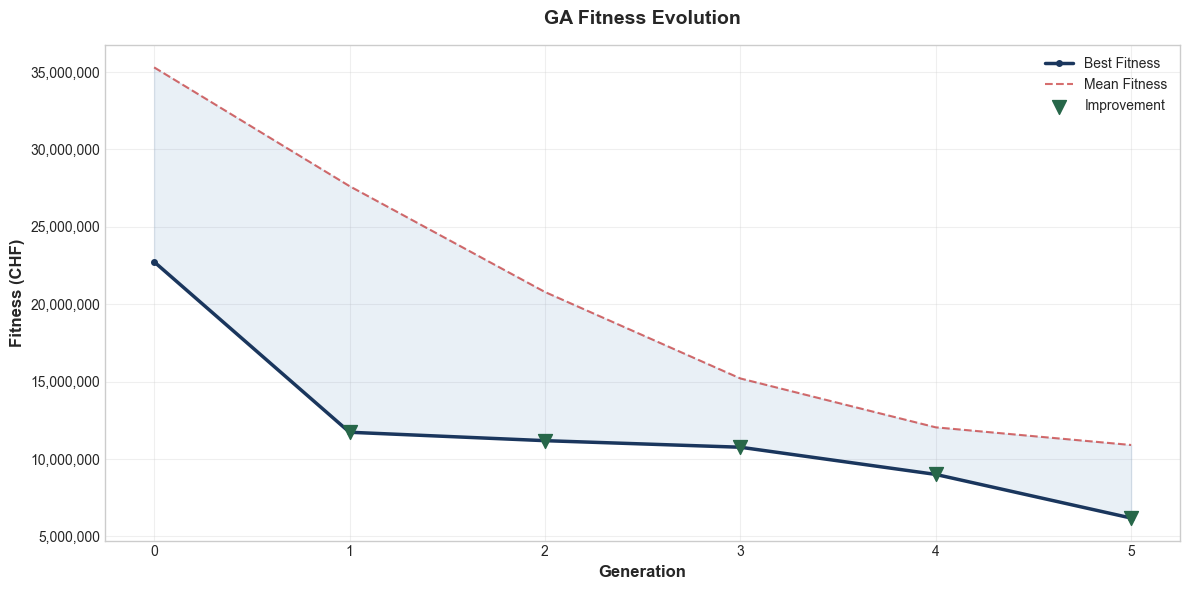

In [409]:
# Plot fitness evolution
fig = plot_fitness_evolution(
    ga_stats.best_fitness_history,
    ga_stats.mean_fitness_history,
    title="GA Fitness Evolution",
    save_path="data/result_plots/fitness_evolution.png"
)
plt.show()


Saved: data/result_plots/portfolio_composition.png


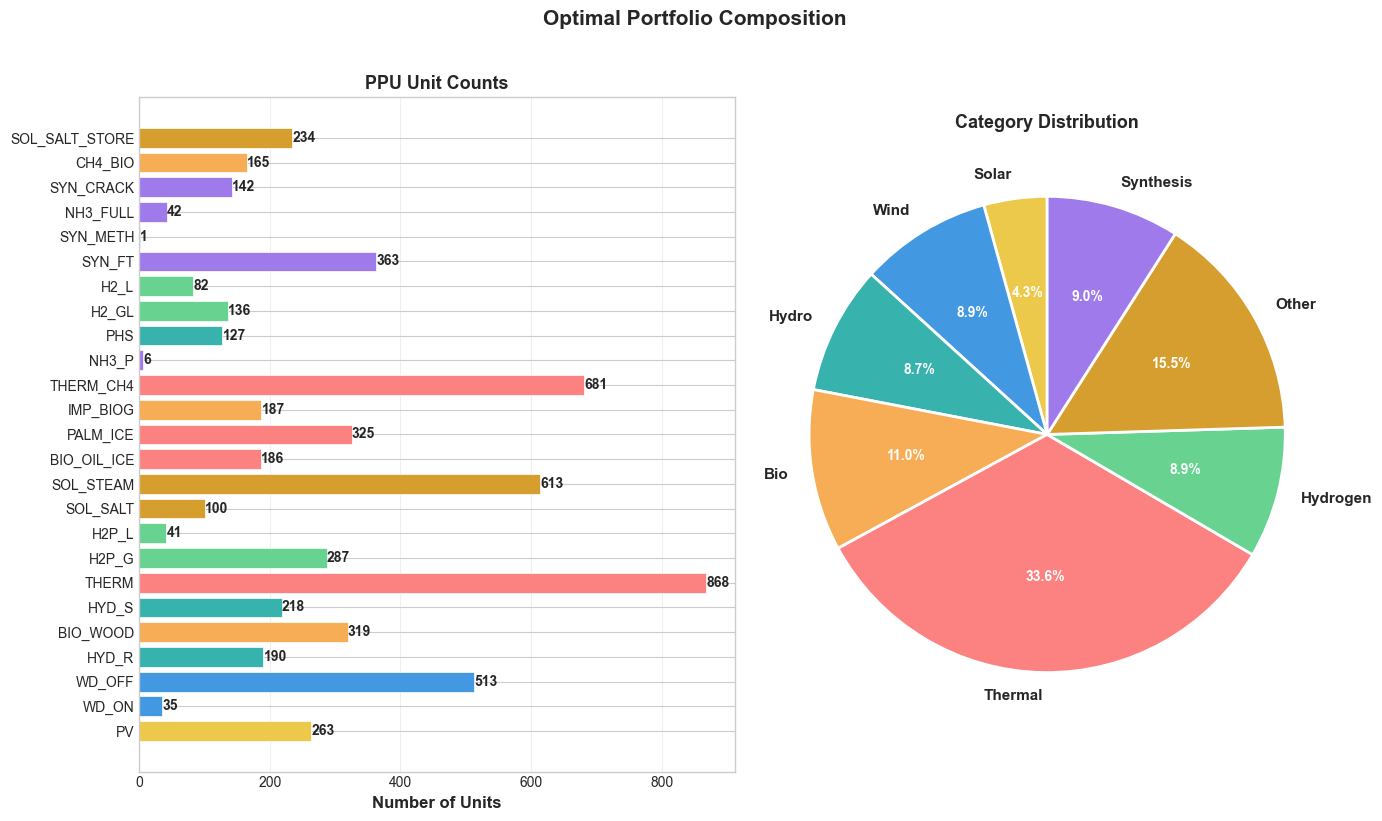

In [410]:
# Plot portfolio composition
fig = plot_portfolio_composition(
    best_individual.portfolio.ppu_counts,
    title="Optimal Portfolio Composition",
    save_path="data/result_plots/portfolio_composition.png"
)
plt.show()


Saved: data/result_plots/optimization_dashboard.png


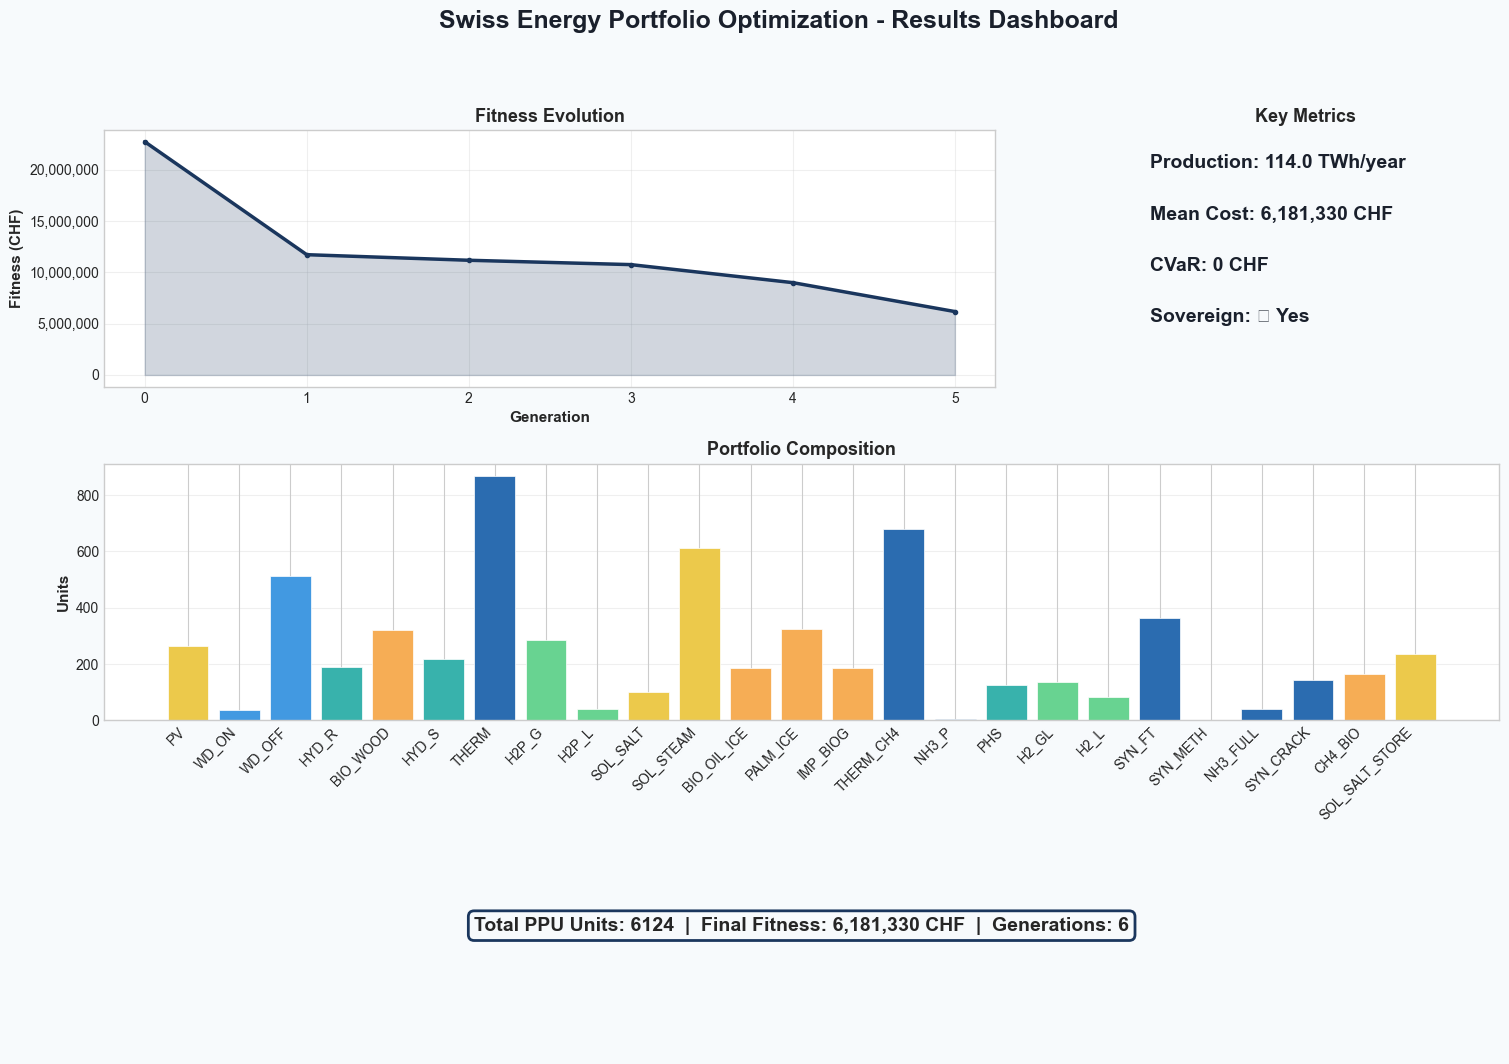

In [411]:
# Create comprehensive dashboard
final_metrics = {
    'annual_production_twh': best_individual.annual_production_twh,
    'mean_cost': best_individual.mean_cost,
    'cvar': best_individual.cvar,
    'is_sovereign': best_individual.is_sovereign,
}

fig = create_optimization_dashboard(
    ga_stats.best_fitness_history,
    best_individual.portfolio.ppu_counts,
    final_metrics,
    title="Swiss Energy Portfolio Optimization - Results Dashboard",
    save_path="data/result_plots/optimization_dashboard.png"
)
plt.show()


In [412]:
# Save final results to CSV for reporting
import os
os.makedirs('data/result_plots', exist_ok=True)

portfolio_df.to_csv('data/result_plots/optimal_portfolio.csv', index=False)

# Save key metrics
metrics_df = pd.DataFrame([{
    'Metric': 'Final Fitness',
    'Value': f"{best_individual.fitness:,.0f} CHF"
}, {
    'Metric': 'Annual Production',
    'Value': f"{best_individual.annual_production_twh:.1f} TWh/year"
}, {
    'Metric': 'Energy Sovereign',
    'Value': 'Yes' if best_individual.is_sovereign else 'No'
}, {
    'Metric': 'Mean Scenario Cost',
    'Value': f"{best_individual.mean_cost:,.0f} CHF"
}, {
    'Metric': 'CVaR (95%)',
    'Value': f"{best_individual.cvar:,.0f} CHF"
}, {
    'Metric': 'Generations',
    'Value': str(ga_stats.generation)
}, {
    'Metric': 'Optimization Time',
    'Value': f"{ga_stats.elapsed_time_s/60:.1f} minutes"
}])

metrics_df.to_csv('data/result_plots/optimization_metrics.csv', index=False)

print("\n✅ Results saved to data/result_plots/")
print("   - optimal_portfolio.csv")
print("   - optimization_metrics.csv")
print("   - fitness_evolution.png")
print("   - portfolio_composition.png")
print("   - optimization_dashboard.png")




✅ Results saved to data/result_plots/
   - optimal_portfolio.csv
   - optimization_metrics.csv
   - fitness_evolution.png
   - portfolio_composition.png
   - optimization_dashboard.png


## Full year

Now we test the optimized portfolio across the **entire year** 
(not random scenarios) to validate its robustness and real-world performance.


In [413]:
# Import full year evaluation function
from optimization import evaluate_portfolio_full_year, FullYearResults
from visualization import (
    plot_full_year_overview,
    plot_full_year_storage,
    plot_full_year_production_by_source
)

# Run full year evaluation on the best portfolio
full_year_results = evaluate_portfolio_full_year(
    best_individual,
    config,
    verbose=True
)


FULL YEAR EVALUATION

Loading full year data...
Loading PPU definitions...


Simulating 8784 hours (366 days)...

FULL YEAR RESULTS
Total Demand:     59.6 TWh
Total Production: 59.6 TWh
Coverage Ratio:   100.0%

Spot Market:
  Bought: 0.00 TWh
  Sold:   0.00 TWh
  Net Cost: 0.0 M CHF

Deficit Analysis:
  Hours in deficit: 0 (0.0%)
  Peak deficit: 0 MW


Saved: data/result_plots/full_year_overview.png


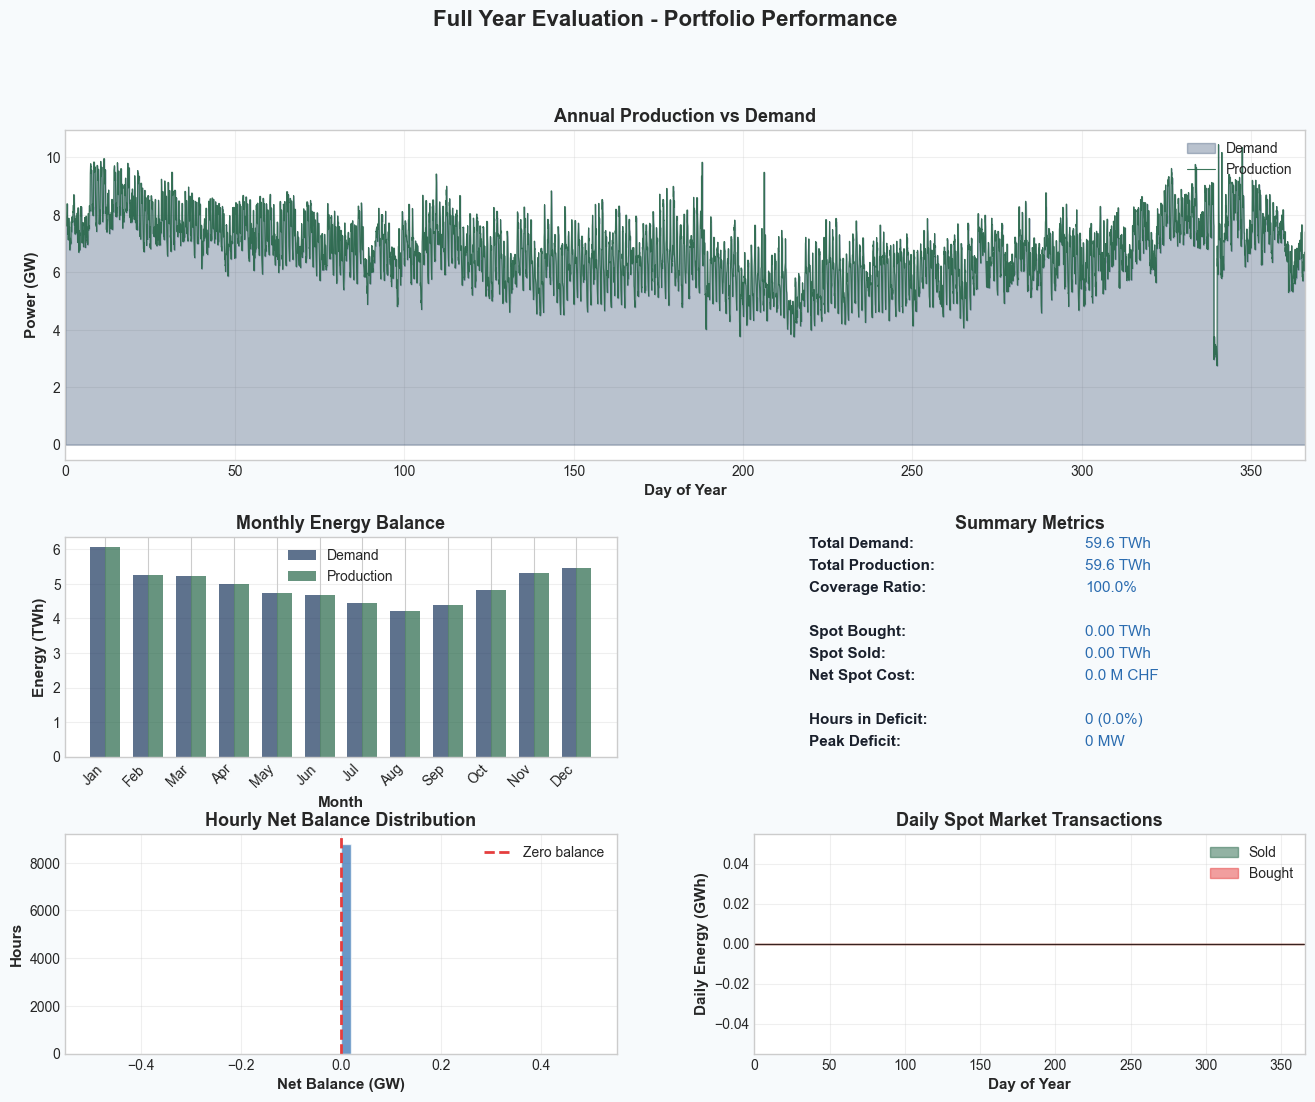

In [414]:
# Full year overview plot
fig = plot_full_year_overview(
    full_year_results,
    title="Full Year Evaluation - Portfolio Performance",
    save_path="data/result_plots/full_year_overview.png"
)
plt.show()


Saved: data/result_plots/full_year_production_by_source.png


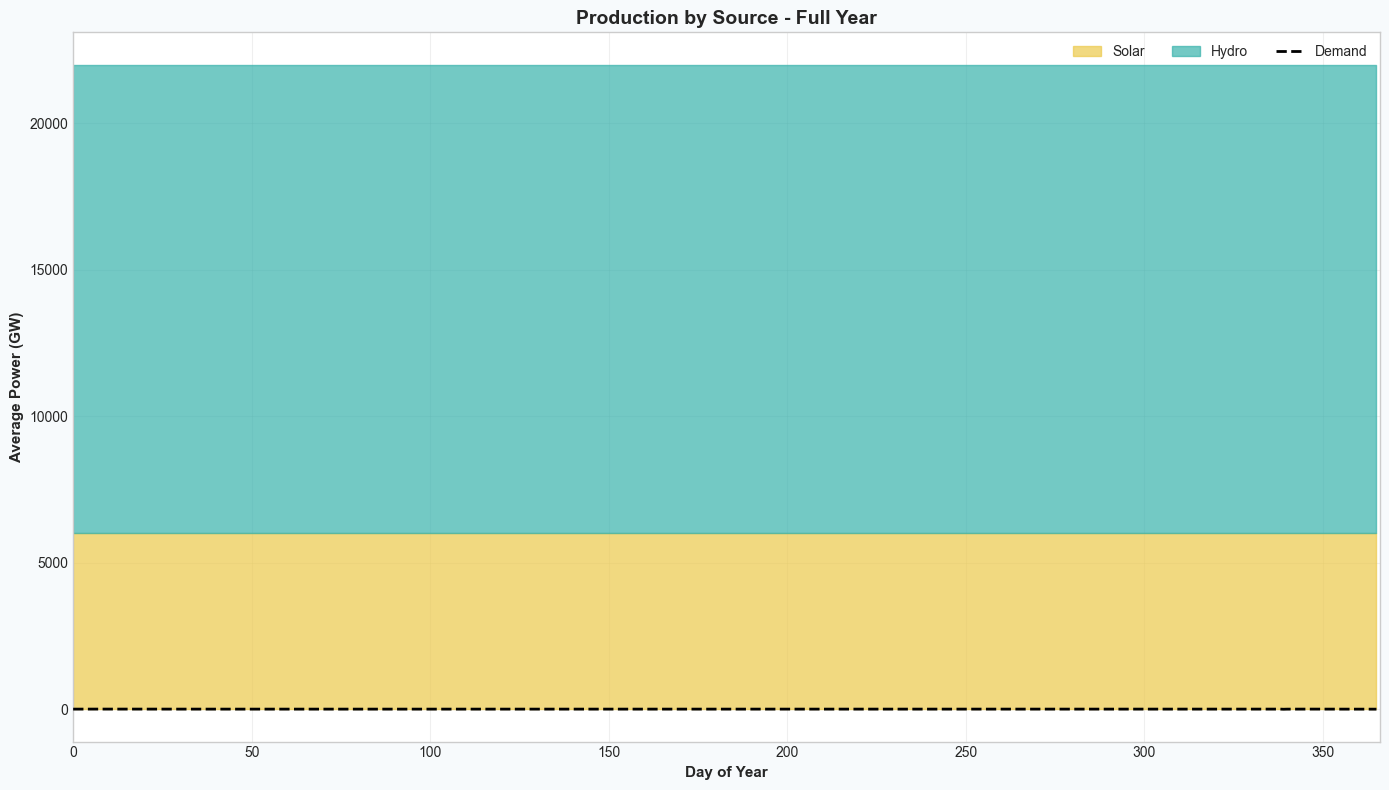

In [415]:
# Production by source (stacked area)
fig = plot_full_year_production_by_source(
    full_year_results,
    title="Production by Source - Full Year",
    save_path="data/result_plots/full_year_production_by_source.png"
)
plt.show()


Saved: data/result_plots/full_year_storage.png


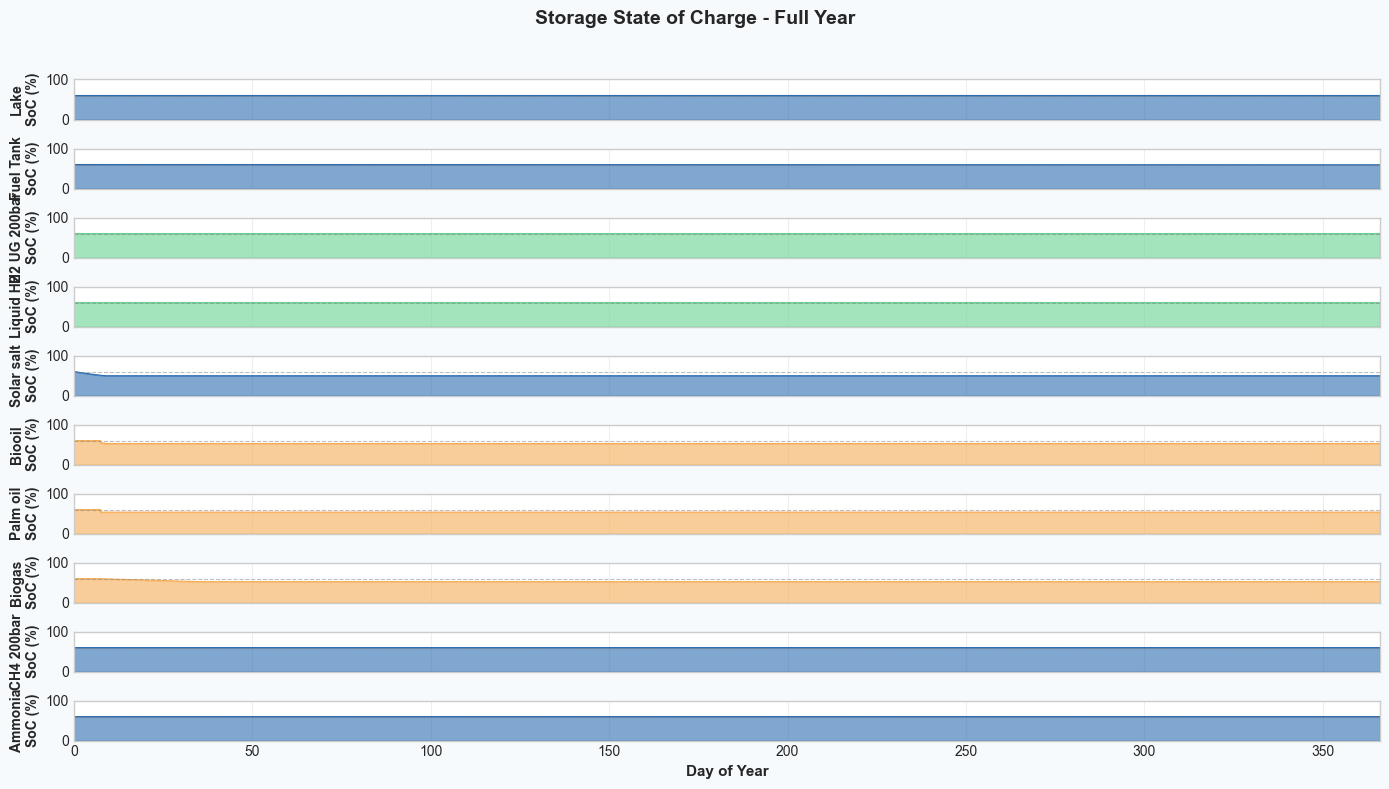

Saved: data/result_plots/scenario_evolution/storage_Lake.png
Saved: data/result_plots/scenario_evolution/storage_Fuel_Tank.png
Saved: data/result_plots/scenario_evolution/storage_H2_UG_200bar.png
Saved: data/result_plots/scenario_evolution/storage_Liquid_H2.png
Saved: data/result_plots/scenario_evolution/storage_Solar_salt.png
Saved: data/result_plots/scenario_evolution/storage_Biooil.png
Saved: data/result_plots/scenario_evolution/storage_Palm_oil.png
Saved: data/result_plots/scenario_evolution/storage_Biogas.png
Saved: data/result_plots/scenario_evolution/storage_CH4_200bar.png
Saved: data/result_plots/scenario_evolution/storage_Ammonia.png

✅ Saved 10 individual storage plots to data/result_plots/scenario_evolution/


[<Figure size 1200x400 with 1 Axes>,
 <Figure size 1200x400 with 1 Axes>,
 <Figure size 1200x400 with 1 Axes>,
 <Figure size 1200x400 with 1 Axes>,
 <Figure size 1200x400 with 1 Axes>,
 <Figure size 1200x400 with 1 Axes>,
 <Figure size 1200x400 with 1 Axes>,
 <Figure size 1200x400 with 1 Axes>,
 <Figure size 1200x400 with 1 Axes>,
 <Figure size 1200x400 with 1 Axes>]

In [416]:
# Storage state of charge over the year
fig = plot_full_year_storage(
    full_year_results,
    title="Storage State of Charge - Full Year",
    save_path="data/result_plots/full_year_storage.png"
)
plt.show()

from visualization import plot_individual_storage

# Save individual storage plots
plot_individual_storage(
    full_year_results,
    save_folder="data/result_plots/scenario_evolution"
)


Saved: data/result_plots/energy_flow.png


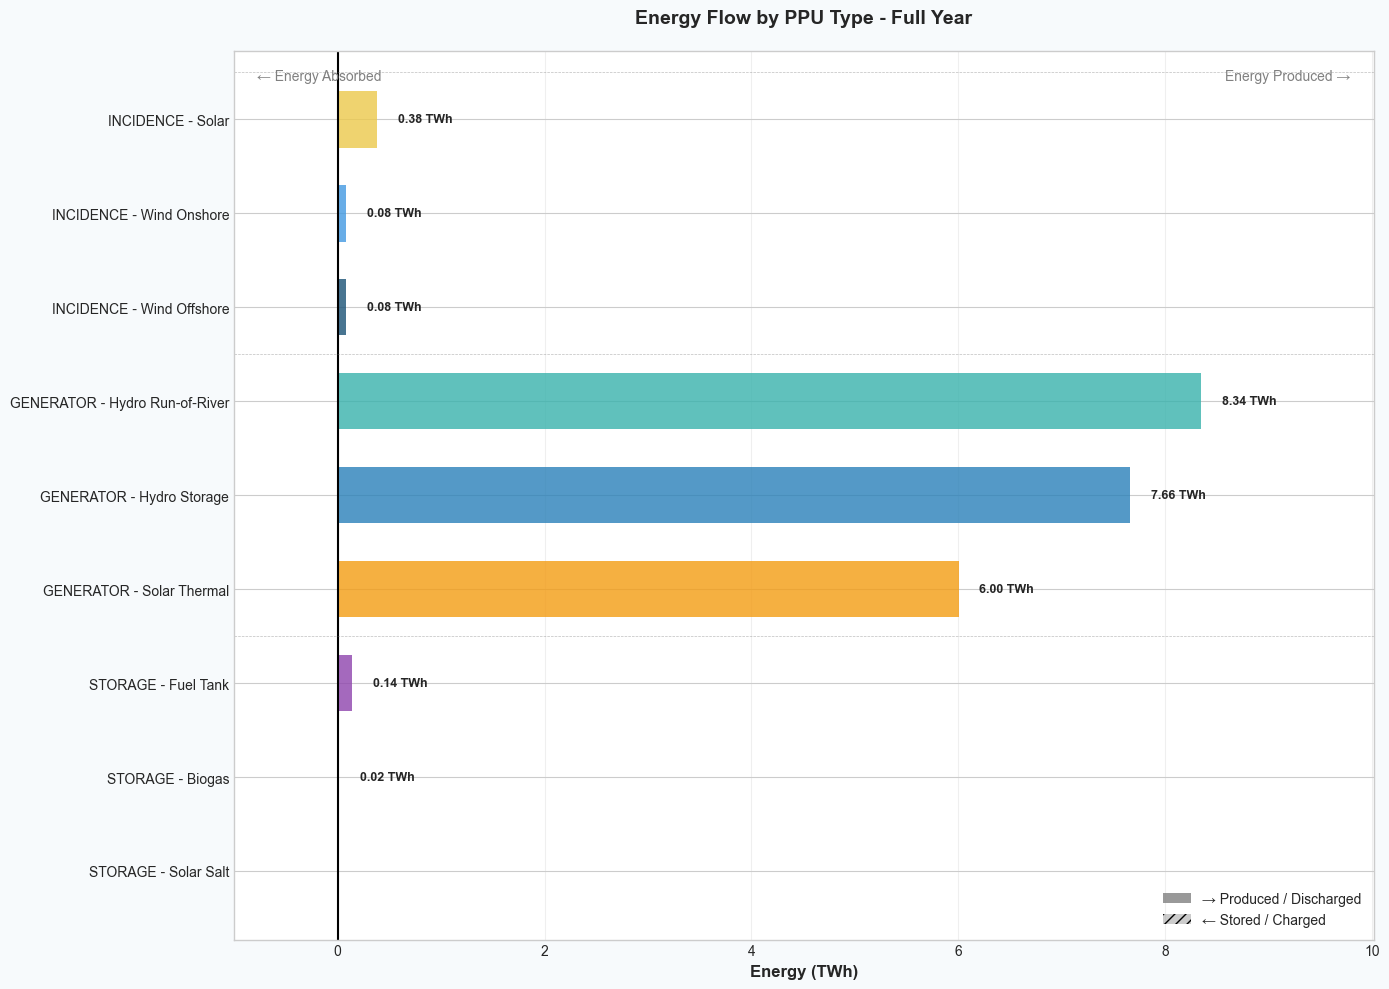

In [417]:
# Energy Flow Visualization - shows production vs storage for each PPU type
from visualization import plot_energy_flow

# Need to run dispatch to get detailed results
from dispatch_engine import run_dispatch_simulation
from ppu_framework import assign_renewable_locations
from optimization import create_ppu_dictionary

# Build PPU dictionary for dispatch
ppu_dict = create_ppu_dictionary(best_individual.portfolio, ppu_definitions, config)
ppu_dict = assign_renewable_locations(ppu_dict, data.solar_ranking, data.wind_ranking)

# Run dispatch simulation
_, dispatch_results = run_dispatch_simulation(
    scenario_indices=np.arange(data.n_hours),
    ppu_dictionary=ppu_dict,
    demand_data=data.get_demand(),
    spot_data=data.get_spot_prices(),
    solar_data=data.get_solar_incidence(),
    wind_data=data.get_wind_incidence(),
    portfolio_counts=best_individual.portfolio.ppu_counts,
    config=config,
    verbose=False,
)

# Create energy flow plot
fig = plot_energy_flow(
    dispatch_results,
    best_individual.portfolio.ppu_counts,
    title="Energy Flow by PPU Type - Full Year",
    save_path="data/result_plots/energy_flow.png"
)
plt.show()

In [418]:
# Summary comparison: Random scenarios vs Full Year
print("=" * 60)
print("COMPARISON: Optimization vs Full Year Validation")
print("=" * 60)
print()
print("During Optimization (Random Scenarios):")
print(f"  Annual Production: {best_individual.annual_production_twh:.1f} TWh/year")
print(f"  Mean Scenario Cost: {best_individual.mean_cost:,.0f} CHF")
print(f"  CVaR (95%): {best_individual.cvar:,.0f} CHF")
print()
print("Full Year Validation:")
print(f"  Total Production: {full_year_results.total_production_twh:.1f} TWh")
print(f"  Total Demand: {full_year_results.total_demand_twh:.1f} TWh")
print(f"  Coverage Ratio: {full_year_results.coverage_ratio*100:.1f}%")
print(f"  Net Spot Cost: {full_year_results.total_spot_cost_chf/1e6:.1f} M CHF")
print(f"  Hours in Deficit: {full_year_results.hours_in_deficit} ({full_year_results.hours_in_deficit/len(full_year_results.demand)*100:.1f}%)")
print()
print("=" * 60)

# Check if portfolio is truly sovereign
if full_year_results.coverage_ratio >= 1.0:
    print("✅ Portfolio PASSES full year validation!")
else:
    shortfall = full_year_results.total_demand_twh - full_year_results.total_production_twh
    print(f"⚠️ Portfolio SHORT by {shortfall:.1f} TWh over the full year")
    print(f"   Consider increasing production capacity or storage.")


COMPARISON: Optimization vs Full Year Validation

During Optimization (Random Scenarios):
  Annual Production: 114.0 TWh/year
  Mean Scenario Cost: 6,181,330 CHF
  CVaR (95%): 0 CHF

Full Year Validation:
  Total Production: 59.6 TWh
  Total Demand: 59.6 TWh
  Coverage Ratio: 100.0%
  Net Spot Cost: 0.0 M CHF
  Hours in Deficit: 0 (0.0%)

✅ Portfolio PASSES full year validation!


DEMAND VOLATILITY ANALYSIS



Saved demand volatility plot: data/result_plots/demand_volatility.png


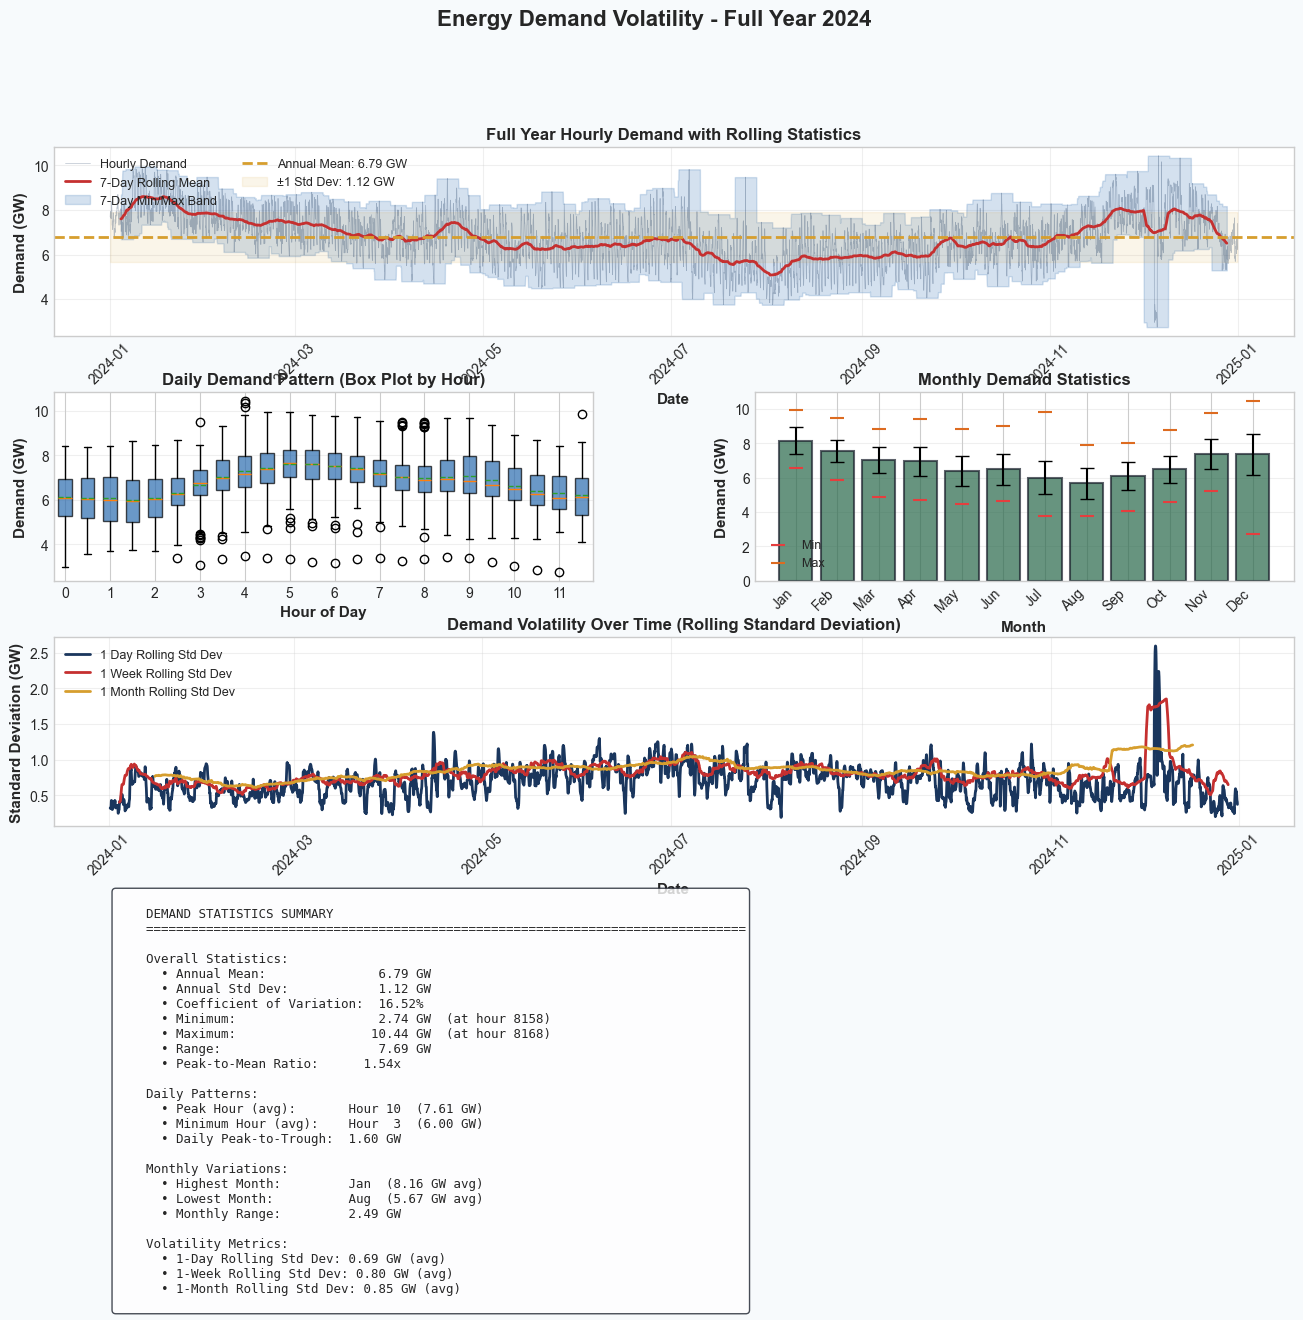


✅ Demand volatility plot saved to data/result_plots/demand_volatility.png


In [419]:
# Plot demand volatility for full year
print("=" * 60)
print("DEMAND VOLATILITY ANALYSIS")
print("=" * 60)
print()

# Load full year demand data
full_year_data = load_all_data(config=config)
demand_full_year = full_year_data.get_demand()

# Create comprehensive demand volatility plot
fig = plot_demand_volatility(
    demand_data=demand_full_year,
    title="Energy Demand Volatility - Full Year 2024",
    save_path="data/result_plots/demand_volatility.png"
)
plt.show()

print("\n✅ Demand volatility plot saved to data/result_plots/demand_volatility.png")


SPOT PRICE VOLATILITY ANALYSIS



Saved spot price volatility plot: data/result_plots/spot_price_volatility.png


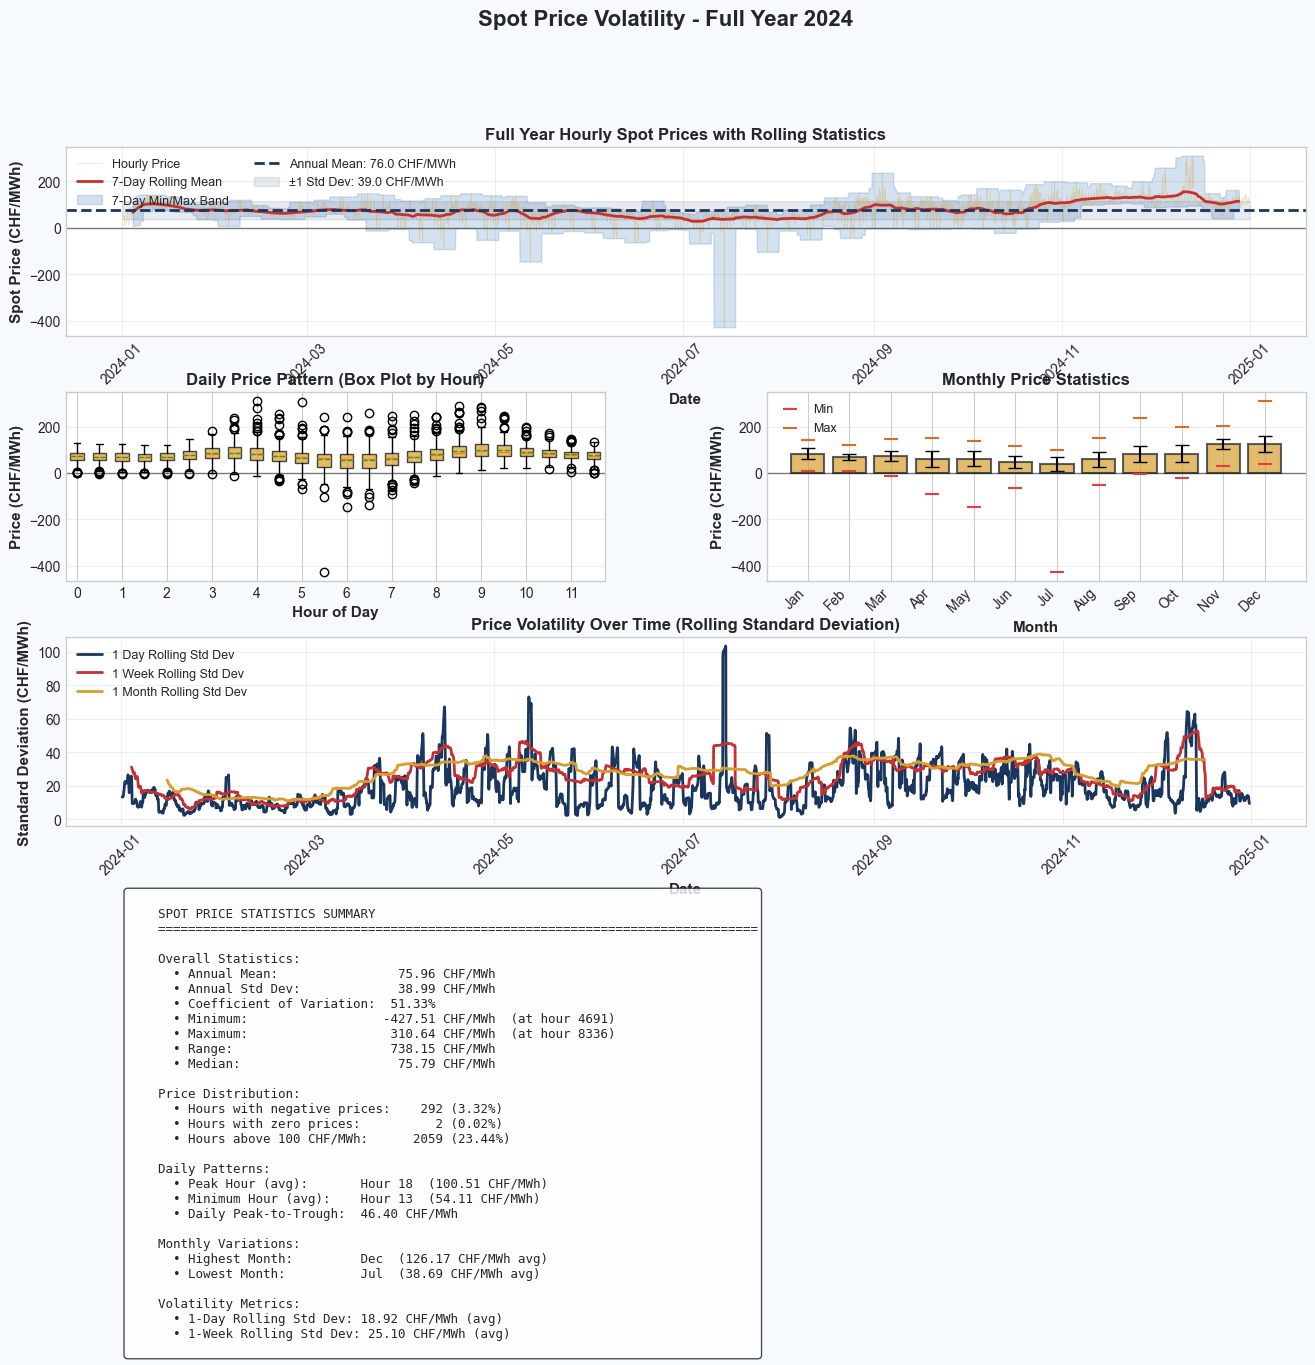


✅ Spot price volatility plot saved to data/result_plots/spot_price_volatility.png


In [420]:
# Plot spot price volatility for full year
print("=" * 60)
print("SPOT PRICE VOLATILITY ANALYSIS")
print("=" * 60)
print()

# Get spot prices from the loaded data
spot_prices_full_year = full_year_data.get_spot_prices()

# Create comprehensive spot price volatility plot
fig = plot_spot_price_volatility(
    spot_data=spot_prices_full_year,
    title="Spot Price Volatility - Full Year 2024",
    save_path="data/result_plots/spot_price_volatility.png"
)
plt.show()

print("\n✅ Spot price volatility plot saved to data/result_plots/spot_price_volatility.png")


SPOT PRICE DISTRIBUTION ANALYSIS



Saved spot price distribution plot: data/result_plots/spot_price_distribution.png


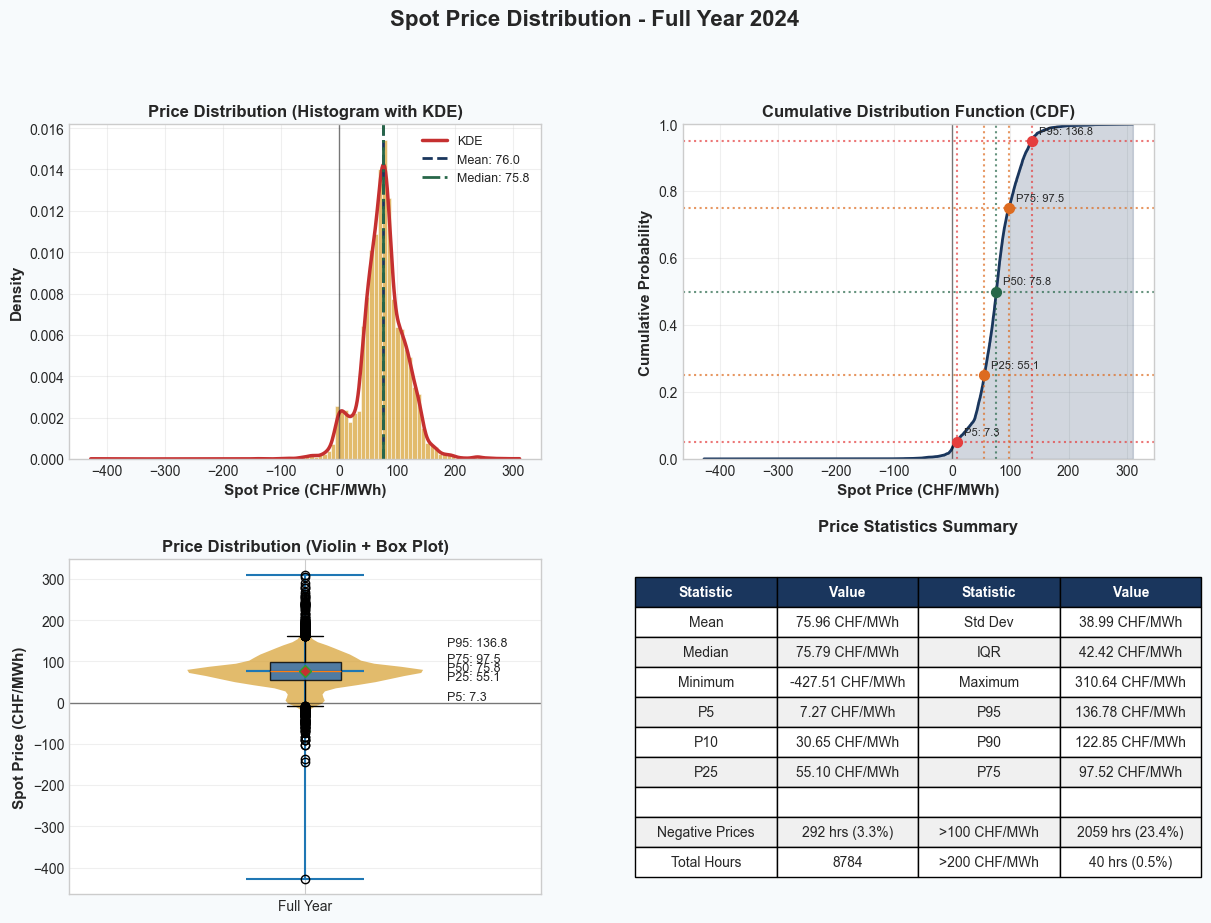


✅ Spot price distribution plot saved to data/result_plots/spot_price_distribution.png


In [421]:
# Plot spot price distribution
print("=" * 60)
print("SPOT PRICE DISTRIBUTION ANALYSIS")
print("=" * 60)
print()

# Create spot price distribution plot
fig = plot_spot_price_distribution(
    spot_data=spot_prices_full_year,
    title="Spot Price Distribution - Full Year 2024",
    save_path="data/result_plots/spot_price_distribution.png"
)
plt.show()

print("\n✅ Spot price distribution plot saved to data/result_plots/spot_price_distribution.png")


In [422]:
# Calculate hourly production costs from the optimized portfolio
print("=" * 60)
print("PORTFOLIO PRODUCTION COST ANALYSIS")
print("=" * 60)
print()

# Calculate weighted average production cost per hour based on PPU usage
# Uses ppu_production from full_year_results and ppu_definitions for costs
# NOTE: PPU costs in ppu_definitions are stored in CHF/kWh (mislabeled as CHF/MWh)
#       The function applies a 1000x conversion factor: 1 CHF/kWh = 1000 CHF/MWh
production_costs = calculate_hourly_production_cost(
    ppu_production=full_year_results.ppu_production,
    ppu_definitions=ppu_definitions,
    total_production_series=full_year_results.total_production,
    renewable_production_series=full_year_results.renewable_production,
    dispatchable_production_series=full_year_results.dispatchable_production,
)

# Handle empty array case
if len(production_costs) == 0:
    print("⚠️ No production cost data available - using placeholder")
    production_costs = np.zeros(len(spot_prices_full_year))

print(f"Portfolio Production Cost (CHF/MWh):")
print(f"  Mean:    {np.mean(production_costs):>8.2f} CHF/MWh")
print(f"  Std dev: {np.std(production_costs):>8.2f} CHF/MWh")
print(f"  Min:     {np.min(production_costs):>8.2f} CHF/MWh")
print(f"  Max:     {np.max(production_costs):>8.2f} CHF/MWh")
print()
print(f"Spot Market Price (CHF/MWh):")
print(f"  Mean:    {np.mean(spot_prices_full_year):>8.2f} CHF/MWh")
print(f"  Std dev: {np.std(spot_prices_full_year):>8.2f} CHF/MWh")
print(f"  Min:     {np.min(spot_prices_full_year):>8.2f} CHF/MWh")
print(f"  Max:     {np.max(spot_prices_full_year):>8.2f} CHF/MWh")
print()

# Summary comparison
diff = np.mean(spot_prices_full_year) - np.mean(production_costs)
print(f"📊 Price Difference: {diff:+.2f} CHF/MWh ({'SAVINGS' if diff > 0 else 'PREMIUM'} vs spot market)")


PORTFOLIO PRODUCTION COST ANALYSIS

Portfolio Production Cost (CHF/MWh):
  Mean:      237.58 CHF/MWh
  Std dev:     3.97 CHF/MWh
  Min:       224.21 CHF/MWh
  Max:       240.41 CHF/MWh

Spot Market Price (CHF/MWh):
  Mean:       75.96 CHF/MWh
  Std dev:    38.99 CHF/MWh
  Min:      -427.51 CHF/MWh
  Max:       310.64 CHF/MWh

📊 Price Difference: -161.63 CHF/MWh (PREMIUM vs spot market)


PRICE DISTRIBUTION COMPARISON

Saved price comparison distribution plot: data/result_plots/price_comparison_distribution.png


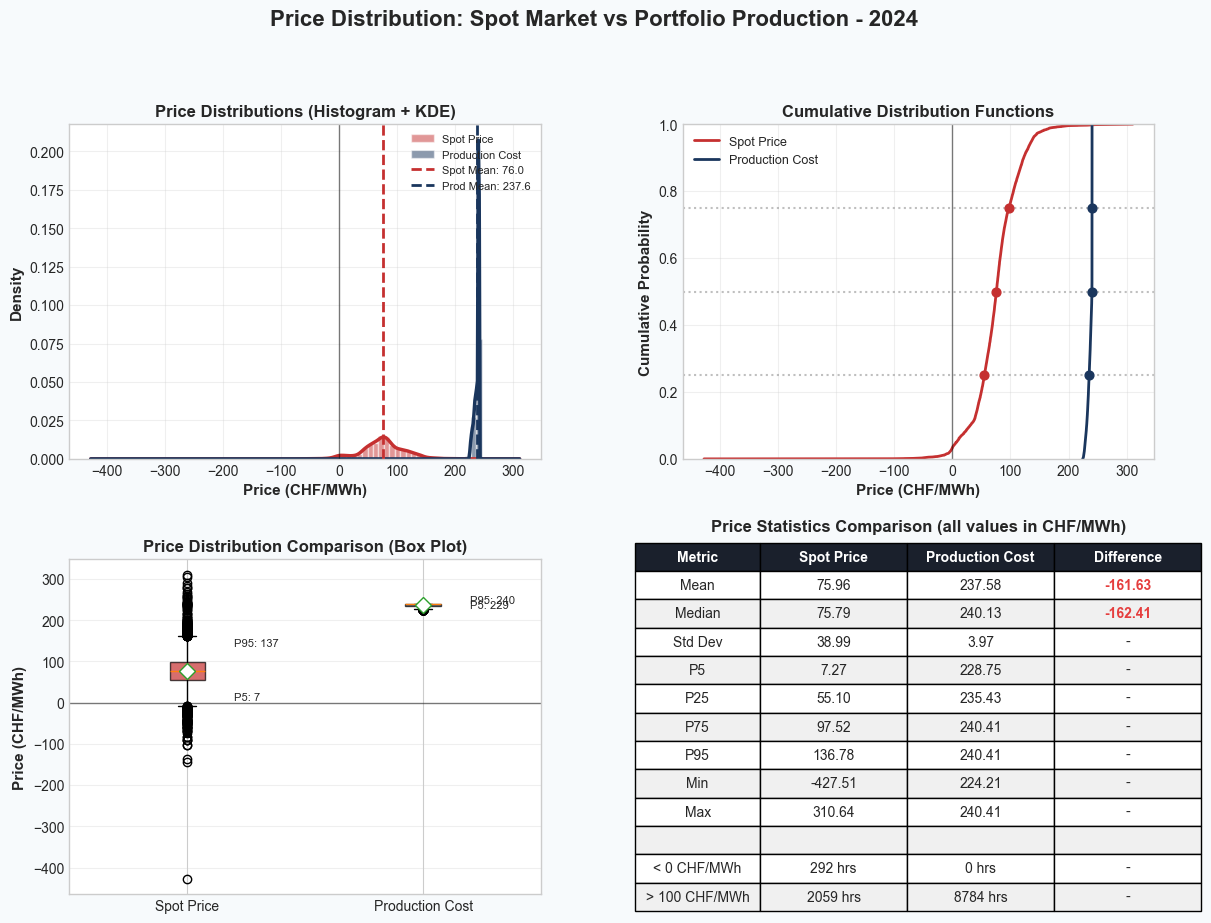


✅ Price comparison distribution plot saved to data/result_plots/price_comparison_distribution.png


In [423]:
# Plot price distribution comparison
print("=" * 60)
print("PRICE DISTRIBUTION COMPARISON")
print("=" * 60)
print()

# Create price distribution comparison plot
fig = plot_price_comparison_distribution(
    spot_prices=spot_prices_full_year,
    production_costs=production_costs,
    title="Price Distribution: Spot Market vs Portfolio Production - 2024",
    save_path="data/result_plots/price_comparison_distribution.png"
)
plt.show()

print("\n✅ Price comparison distribution plot saved to data/result_plots/price_comparison_distribution.png")


PORTFOLIO COST BREAKDOWN - IDENTIFYING HIGH COST DRIVERS

This analysis shows which components across your optimized portfolio
are responsible for the high production costs.

Saved portfolio cost breakdown plot: data/result_plots/portfolio_cost_breakdown.png


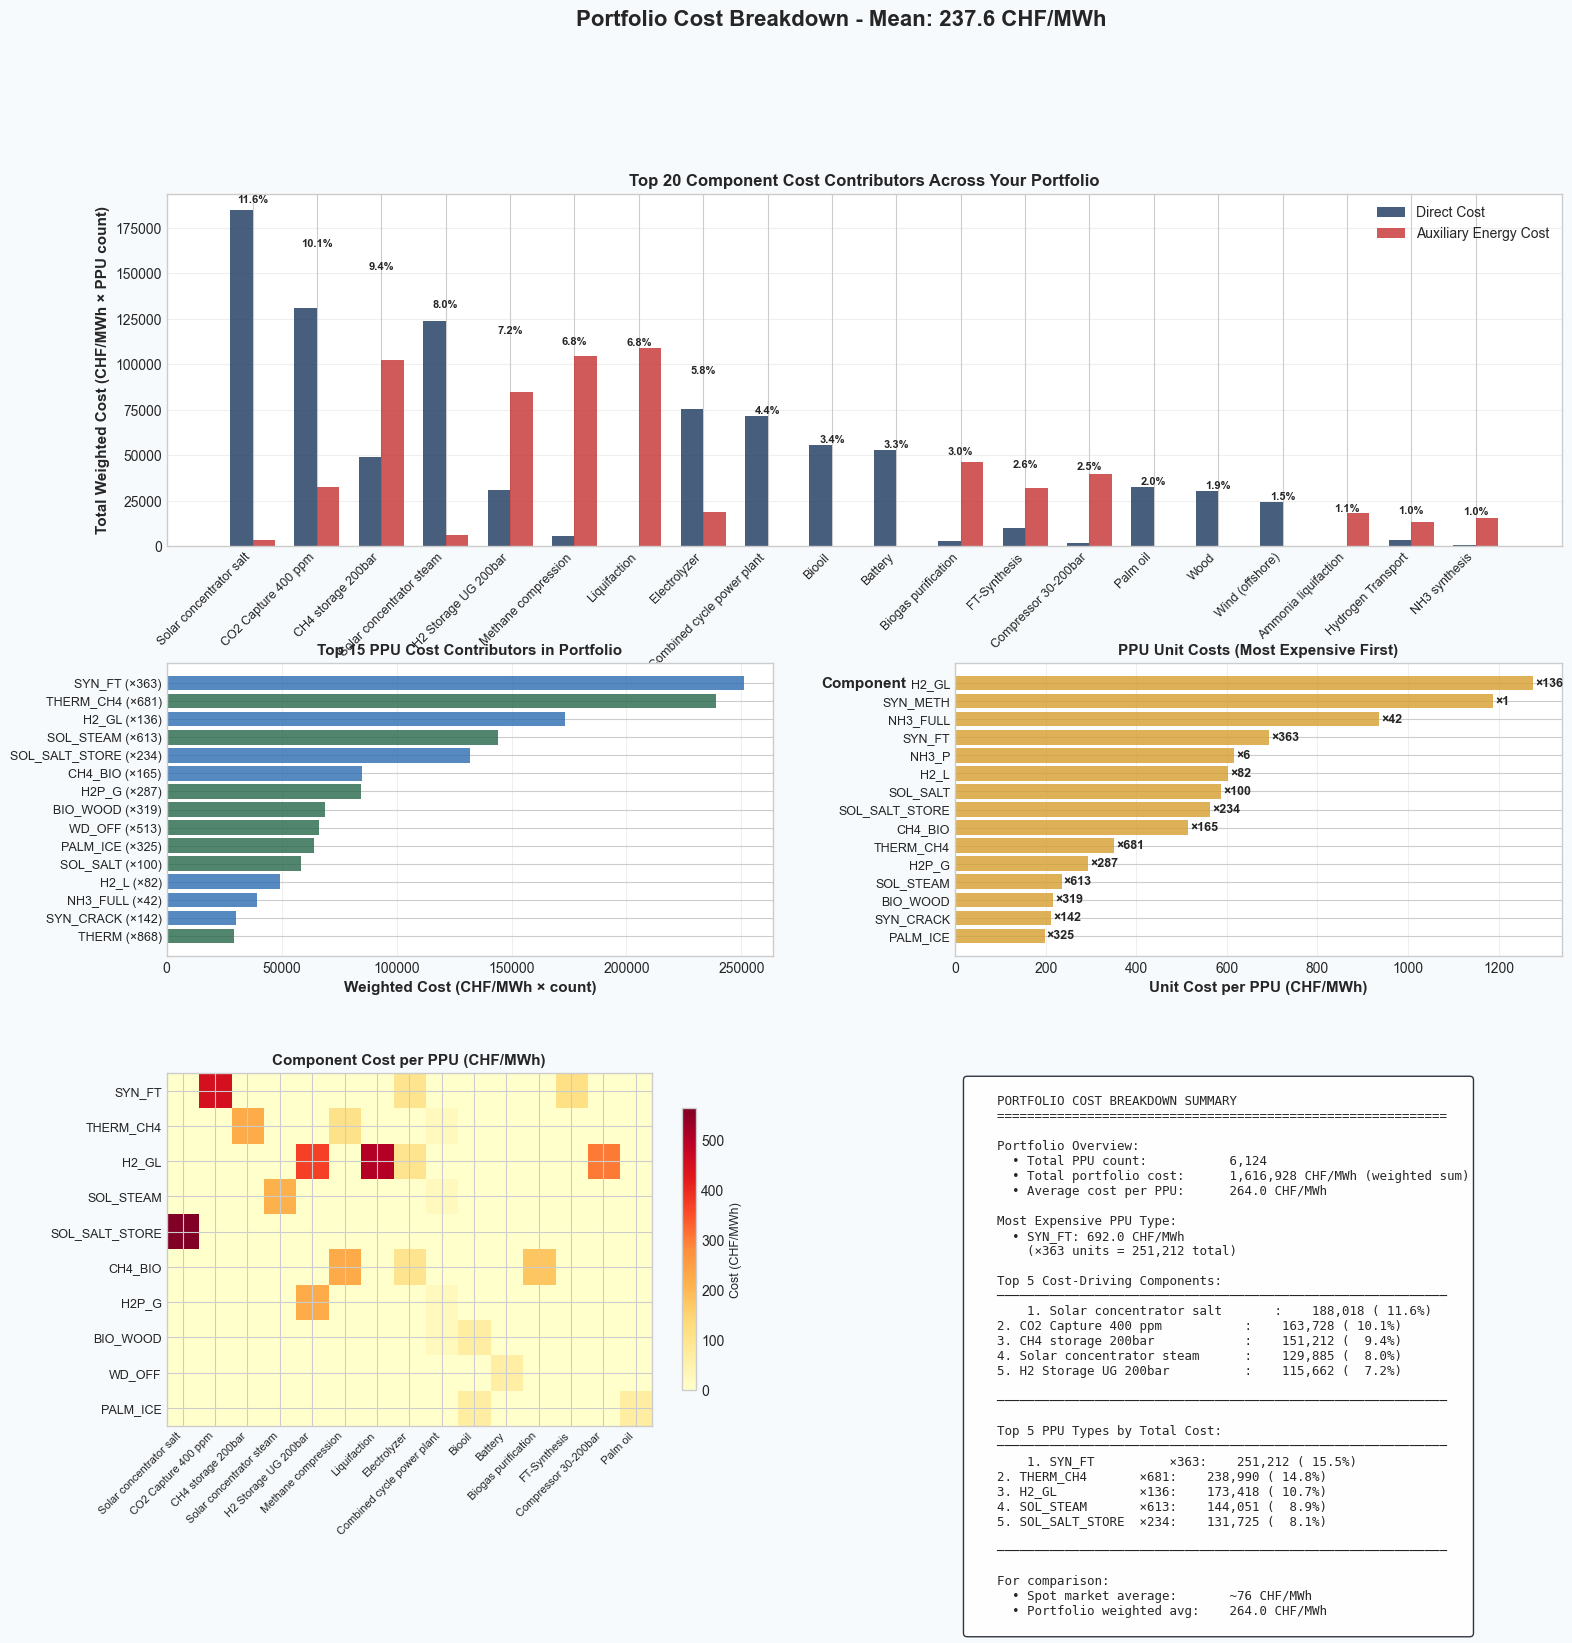


✅ Portfolio cost breakdown plot saved to data/result_plots/portfolio_cost_breakdown.png


In [424]:
# Analyze portfolio cost breakdown by components
print("=" * 60)
print("PORTFOLIO COST BREAKDOWN - IDENTIFYING HIGH COST DRIVERS")
print("=" * 60)
print()
print("This analysis shows which components across your optimized portfolio")
print("are responsible for the high production costs.")
print()

# Create portfolio cost breakdown visualization using the optimized portfolio
fig = plot_portfolio_cost_breakdown(
    portfolio=best_individual.portfolio.ppu_counts,
    ppu_definitions=ppu_definitions,
    ppu_constructs_df=constructs_df,
    cost_df=cost_df,
    title=f"Portfolio Cost Breakdown - Mean: {np.mean(production_costs):.1f} CHF/MWh",
    save_path="data/result_plots/portfolio_cost_breakdown.png",
)
plt.show()

print("\n✅ Portfolio cost breakdown plot saved to data/result_plots/portfolio_cost_breakdown.png")


In [425]:
# Save full year results
full_year_metrics = pd.DataFrame([
    {'Metric': 'Total Demand (TWh)', 'Value': f"{full_year_results.total_demand_twh:.1f}"},
    {'Metric': 'Total Production (TWh)', 'Value': f"{full_year_results.total_production_twh:.1f}"},
    {'Metric': 'Coverage Ratio', 'Value': f"{full_year_results.coverage_ratio*100:.1f}%"},
    {'Metric': 'Spot Bought (TWh)', 'Value': f"{full_year_results.total_spot_bought_mwh/1e6:.2f}"},
    {'Metric': 'Spot Sold (TWh)', 'Value': f"{full_year_results.total_spot_sold_mwh/1e6:.2f}"},
    {'Metric': 'Net Spot Cost (M CHF)', 'Value': f"{full_year_results.total_spot_cost_chf/1e6:.1f}"},
    {'Metric': 'Hours in Deficit', 'Value': f"{full_year_results.hours_in_deficit}"},
    {'Metric': 'Peak Deficit (MW)', 'Value': f"{full_year_results.peak_deficit_mw:.0f}"},
])

full_year_metrics.to_csv('data/result_plots/full_year_metrics.csv', index=False)

print("\n✅ Full year results saved to data/result_plots/")
print("   - full_year_overview.png")
print("   - full_year_production_by_source.png")
print("   - full_year_storage.png")
print("   - full_year_metrics.csv")



✅ Full year results saved to data/result_plots/
   - full_year_overview.png
   - full_year_production_by_source.png
   - full_year_storage.png
   - full_year_metrics.csv


---

## Conclusion

This notebook demonstrates a complete optimization pipeline for Swiss energy portfolio planning:

1. **Data-driven approach**: Uses 2024 hourly data for demand, renewables, and spot prices
2. **Energy sovereignty**: Ensures the portfolio can produce ≥113 TWh/year
3. **Robust evaluation**: Tests each portfolio across multiple random scenarios
4. **Sophisticated dispatch**: Implements storage management with disposition indices
5. **Genetic optimization**: Efficiently explores the solution space
6. **Full year validation**: Tests the optimized portfolio across the entire year

The optimal portfolio balances renewable sources (solar, wind) with storage capabilities and flexible generation to meet Switzerland's energy needs reliably and cost-effectively.
